In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [ ]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [ ]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [ ]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

From examining the different types of seeds we can see that there is an even ratio of seeds to eachother

In [ ]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values

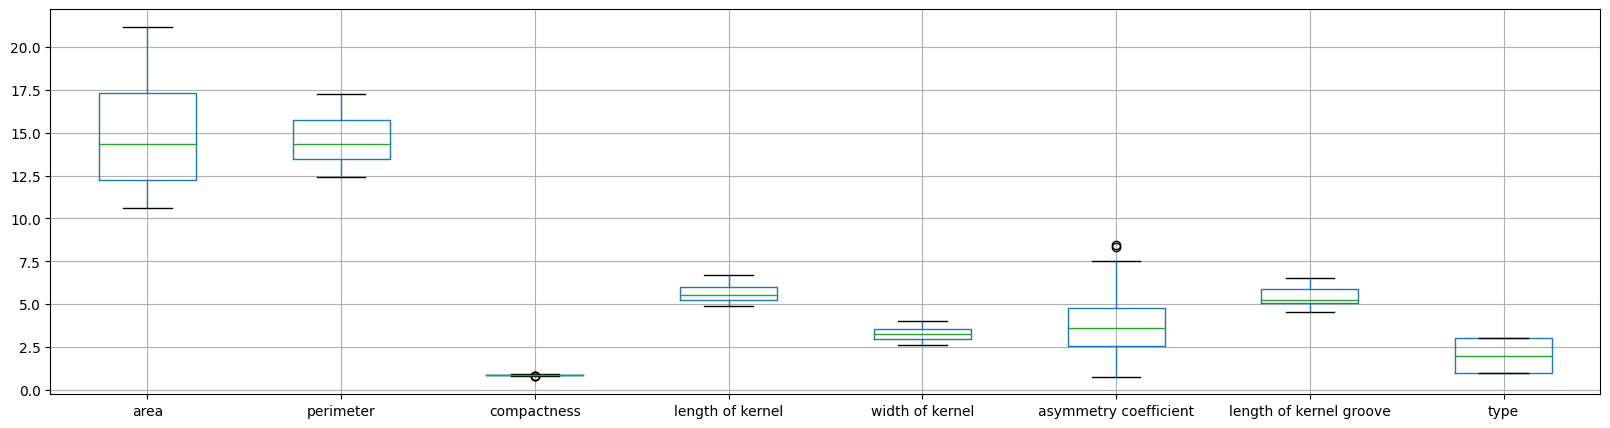

In [ ]:
df.boxplot(figsize=(20,5))
plt.show()

From reviewing the plot we can conclude that the only outlier is present in asymmetry coefficien

**Change to binary**

In [ ]:
mapper = {1 : 1
           , 2 : 0,
           3: 0 }
df['type'] = df['type'].replace(mapper)

In [ ]:
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

**DP**


In [ ]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient','compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [ ]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]


In [ ]:

preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [ ]:

y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Clasifiers

In [ ]:
#SVM classifier
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])


param_grid = {
    'svm__C': [0.1, 1, 10, 50, 100, 200],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# save the best params and best model
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.971:
Best parameters:  {'svm__C': 200, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [ ]:
#Random Forest
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])


param_grid = {
    'rf__n_estimators' : [10,15,20,30,50],
    'rf__max_depth': [2, 4, 6, 8, 10]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# save the best params and best model
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.935:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])


param_grid = {
    'knn__weights' : ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

search = GridSearchCV(pipe, param_grid, cv=10,refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# savee the best params and best model
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.917:
Best parameters:  {'knn__algorithm': 'auto', 'knn__weights': 'uniform'}


**Compare**

In [ ]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc

def evaluate_model(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]
    _predicted_values = model.predict(X_test)
    _accuracy = accuracy_score(y_test, _predicted_values)
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
    _auc = auc(_fpr, _tpr)
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr, _auc

In [ ]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)


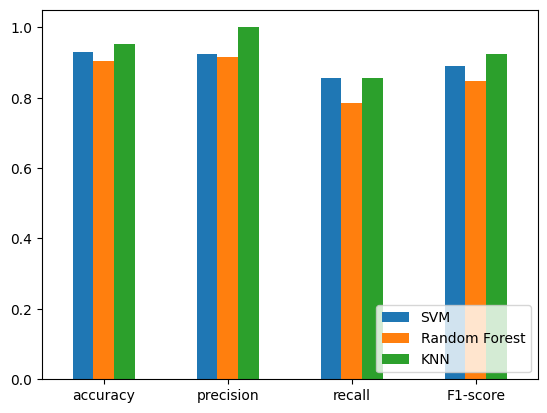

In [ ]:

SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])


index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

In [ ]:

# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)